In [1]:
%matplotlib notebook
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

### Constants

In [2]:
rd = {}
xSize = 3
numPoints = 200 #the number of points generated for visualization.
numRays = 2*2**xSize

### Graph Builder

In [3]:
def build_graph(rd, xSize):
    x = tf.placeholder(tf.float64, shape=[None, xSize])
    y = x[:,0]*1.
    #add large cycles
    for i in range(xSize):
        r = np.random.uniform(-5., 5.)
        y = y + 3*tf.sin(x[:,i]/(10+r)+r)
    #add medium cycles
    for i in range(xSize):
        r = np.random.uniform(-2.,2.)
        y = y + 2*tf.cos(x[:,i]/(3+r)+r)
    #add short cycles
    for i in range(xSize):
        r = np.random.uniform(3.)
        y = y + 0.5*tf.sin(x[:,i]*r)
    
    rd['y'] = y
    rd['x'] = x
    rd['yPrime'] = tf.gradients(y, x)

### Distribution Builder

In [4]:
def build_explorer(rd, xSize):
    
    std = 2. #the initial standard deviation of the gaussian drop zone.
    mean = tf.Variable(np.random.uniform(-5, 5, size=(xSize,))) #the mean of the gaussian drop zone.
    cov = tf.Variable(np.identity(xSize)*std**2) # the covariance of the drop zone.
    
    newMean = tf.placeholder(tf.float64, shape=xSize)
    setMean = (mean/mean)*newMean
    
    rd['newMean'] = newMean
    rd['setMean'] = setMean
    rd['mean'] = mean
    rd['cov'] = cov
    

### Get Graph and Session

In [5]:
build_graph(rd, xSize)
build_explorer(rd, xSize)
rd['sess'] = tf.Session()
rd['sess'].run(tf.initialize_all_variables())

### Get Drop Zone Parameters

In [6]:
def drop_zone_params(rd):
    meancov = rd['sess'].run([rd['mean'], rd['cov']])
    mean = meancov[0]
    cov = meancov[1]
    
    return mean, cov

### Generate f(x)

In [7]:
def f_of_x(rd, mean, cov):
    x = np.random.multivariate_normal(mean=mean, cov=cov*1.5, size=numPoints)
    result = rd['sess'].run([rd['y']], feed_dict={rd['x']:x})
    y = result[0]
    return x, y

### Generate Gradient Vectors

In [8]:
def f_prime_of_x(rd, mean, cov):
    rays = np.random.multivariate_normal(mean=mean, cov=cov, size=numRays)
    grads = rd['sess'].run(rd['yPrime'], feed_dict={rd['x']:rays})
    vecs = grads[0]*-1.  # make rear facing, i.e. downhill.

    avgRay = np.mean(rays, axis=0)
    avgVec = np.mean(vecs, axis=0)
    avgVecMag = np.mean(np.absolute(vecs), axis=0)
    devVec = np.mean(np.absolute(avgVec - vecs), axis=0)
    
    devPerc = devVec/avgVecMag
    
    return rays, vecs, avgRay, avgVec, devPerc

### Calculate Vector Intersections

In [9]:
def closest_intersections(rays, vecs):
    #see http://geomalgorithms.com/a07-_distance.html
    #O(n**2) currently. : /
    #   i think the first way to improve this will be to remove rays
    #    that do not share an acute angle in the direction of their vector?
    #    maybe choose the most acute angle relationship before going to all this effort?
    #   is there any way to do this with a sweep line?
    
    #FIXME np.diag() is used below, and the off diagonal elements are never used.
    #        so, multiply that stuff without calculating the off diagonal elements.
    
    #NOTE: np.dot(a, b) sums over the last dimension of a, and the 2nd to last of b
    #
    assert rays.shape == vecs.shape
    
    bestFront = []
    bestRear = []
    
    #calculate full vector info outside of loop.
    v = vecs  # .shape == (r, 3)
    v = np.expand_dims(v, 2)  # .shape == (r, 3, 1)
    c = np.dot(np.rollaxis(v, -1, -2), v)  # c.shape == (r, 1, r, 1)
    c = np.squeeze(c)  # c.shape == (r, r)
    #take the diagonal to only get those dotted by themselves
    c = np.diag(c)  # c.shape == (r,)  <---C
    
    
    #iterate each ray
    for i in range(rays.shape[0]):
        #print i
        
        u = vecs[i]  # .shape == (3,)
        wNil = rays[i] - rays  # .shape == (r, 3)
        wNil = np.expand_dims(wNil, 2)  # .shape == (r, 3, 1)
        
        a = np.dot(u, u)  # a.shape == (1,) <---A
        b = np.dot(u, v)  # b.shape == (r, 1, 1)
        b = np.squeeze(b)  # b.shape == (r,)  <---B
        # c.shape == (r,)  <---C
        d = np.dot(u, wNil)  # d.shape == (r, 1, 1)
        d = np.squeeze(d)  # d.shape == (r,)  <---D
        e = np.dot(np.rollaxis(v, -1, -2), wNil)  # e.shape == (r, 1, r, 1)
        e = np.squeeze(e)  # e.shape == (r, r)
        e = np.diag(e)  # e.shape == (r,)  <---E
        
        denominator = (a*c) - b**2  # .shape == (r,)
        #throw out parallel lines
        intersecting = np.where(denominator > 0)
        b_ = b[intersecting]
        c_ = c[intersecting]
        d_ = d[intersecting]
        e_ = e[intersecting]
        denominator_ = denominator[intersecting]
        
        s = ((b_*e_)-(c_*d_))/denominator_  # distance from P0 on ray[i] closest to...
        t = ((a*e_)-(b_*d_))/denominator_  # the point t distance from Q0
        
        #s.shape == (r,)
        #t.shape == (r,)
        #NOTE: positive s/t indicate that the meeting point is in front of the vector, negative indicates behind.
        
        #Get the points along the rays given s and t.
        Ps = np.expand_dims(rays[i], 0) + np.expand_dims(u, 0)*np.expand_dims(s, 1)  # .shape == (r, 3)
        Pt = rays[intersecting] + vecs[intersecting]*np.expand_dims(t, 1)  # .shape == (r, 3)
        
        
        #calculate closest intersection for ray[i]
        #  NOTE: this does not calculate the intersection closest to its origin.
        dists = (Pt-Ps)**2
        dists = dists.sum(axis=1)
        dists = np.sqrt(dists)
        
        #FIXME TODO the best intersection is some product of closeness of intersection AND in closeness to
        #             the origin of the ray.
        #             the relationships should probably be squared? so that values with both are very highly prized.
        
        #equality would be unhelpful?
        #find where both rays are pos/neg
        #   i.e. where they agree on the status of the intersection. max/min
        fIndex = np.argwhere((s > 0) & (t > 0)).squeeze(axis=1)
        rIndex = np.argwhere((s < 0) & (t < 0)).squeeze(axis=1)
        
        #we want dist to be small, and s to be small.
        #a combination of both is far greater than one or the other.
        if fIndex.size > 0:
            bestFIndex = fIndex[(s[fIndex] * dists[fIndex]).argmin()]
            midF = (Ps[bestFIndex]+Pt[bestFIndex])/2
            bestFront.append(midF)
        
        if rIndex.size > 0:            
            bestRIndex = rIndex[((s[rIndex]*-1) * dists[rIndex]).argmin()]
            midR = (Ps[bestRIndex]+Pt[bestRIndex])/2
            bestRear.append(midR)
    
    return np.array(bestFront), np.array(bestRear)


rd['sess'].run([rd['setMean']], feed_dict={rd['newMean']:avgFront})

In [10]:
mean, cov = drop_zone_params(rd)
x, y = f_of_x(rd, mean, cov)
rays, vecs, avgRay, avgVec, devPerc = f_prime_of_x(rd, mean, cov)

fronts, rears = closest_intersections(rays, vecs)

avgFront = np.mean(fronts, axis=0)
print avgFront
avgRear = np.mean(rears, axis=0)
print avgRear


[-0.43128522 -3.5554987   5.6965975 ]
[ 2.00117085 -3.38744896  4.2639028 ]


### TODO
Test a cascade where intersections are used as the next iteration's ray origins. Cull outliers and repeats, and redistribute from the average intersection back to the right number of rays.

## Plot

In [11]:
#transpose for easier matplotlib plotting
x = x.transpose()
y = np.squeeze(y)
rays = rays.transpose()
vecs = vecs.transpose()

<IPython.core.display.Javascript object>


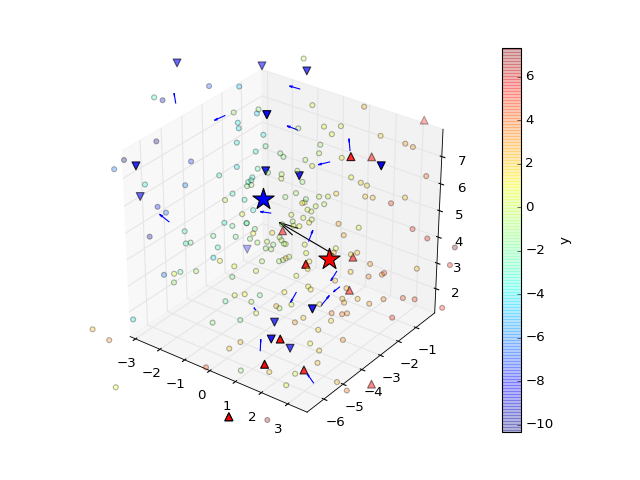

Deviation Percent: [ 0.78746341  0.96067525  0.82394034]


In [12]:
plotSplit = 110
lims = (mean-(np.mean(cov)*5/2.), mean+(np.mean(cov)*5/2.))

fig = plt.figure()

ax = fig.add_subplot(plotSplit+1, projection='3d') #create subplot in figure.
ax.set_xlim(lims[0][0], lims[1][0])
ax.set_ylim(lims[0][1], lims[1][1])
ax.set_zlim(lims[0][2], lims[1][2])
#ptIndices = []
#for i in range(x.shape[0]):
#    ptIndices.append(list((x[i,:] >= lims[0][i]) & (x[i,:] <= lims[1][i])))
#ptIndices = np.array(ptIndices).all(axis=0)

x1 = x[0]#ptIndices]
x2 = x[1]#ptIndices]
x3 = x[2]#ptIndices]
#set the color map to the output dimension.
scatPlot = ax.scatter(x1, x2, x3, alpha=0.3, marker='o', c=y)#[ptIndices])
cb = fig.colorbar(scatPlot)
cb.set_label("y")
#cb.set_clim(vmin=y[ptIndices].min, vmax=y[ptIndices].max())

#gradient rays
ax.quiver(rays[0], rays[1], rays[2], vecs[0], vecs[1], vecs[2], length=0.4)
ax.quiver(avgRay[0], avgRay[1], avgRay[2], avgVec[0], avgVec[1], avgVec[2],
          length=2, colors=(0,0,0))

#gradient ray intersections
if fronts.size >= 3:
    ax.scatter(fronts[:,0], fronts[:,1], fronts[:,2], marker='v', s=50, c=(0,0,1))
    ax.scatter(avgFront[0], avgFront[1], avgFront[2], marker='*', s=400, c=(0,0,1))
if rears.size >= 3:
    ax.scatter(rears[:,0], rears[:,1], rears[:,2], marker='^', s=50, c=(1,0,0))
    ax.scatter(avgRear[0], avgRear[1], avgRear[2], marker='*', s=400, c=(1,0,0))

    
print "Deviation Percent: " + str(devPerc)